#Автоматическая обработка документов. Кроп документов.

**Автор**: Мельникова Елена

**Группа**: M05-316б



#Установка библиотек

In [ ]:
!git clone https://github.com/ML-MountainLover/course_ocr.git

In [ ]:
%cd /content/course_ocr/task1

In [ ]:
!pip install pytorch_lightning

In [ ]:
!pip install segmentation_models_pytorch

In [5]:
from pathlib import Path
from course_ocr_t1.data import MidvPackage
from course_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy
from course_ocr_t1.metrics import iou_relative_quads
from tqdm import tqdm
from matplotlib import pyplot as plt
from google.colab import drive
import numpy as np
import pandas as pd
import glob
import os
import albumentations as A
import cv2
import pytorch_lightning as pl
import torch
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms
import json
from pytorch_lightning.callbacks import Callback, ModelCheckpoint, LearningRateMonitor
from shapely import Polygon
import segmentation_models_pytorch as smp

In [ ]:
!sudo apt update
!sudo apt install p7zip-full

#Загрузка данных

In [ ]:
!gdown 1W2BDEhQa2kQsMu1EG1JMInzxJ6RAQ4i5
!7za x /content/course_ocr/task1/midv500_compressed.7z

In [8]:
DATASET_PATH = Path()/ '/content/course_ocr/task1/midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [9]:
# Собираем список пакетов (MidvPackage)
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_ocr_t1.data.MidvPackage)

In [10]:
## Статистика, как часто разметка не целиком в кадре
is_quad_inside = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_quad_inside.append(dp[i].is_quad_inside())
is_quad_inside = np.array(is_quad_inside).astype(int)
print(f"В {is_quad_inside.sum()} из {len(is_quad_inside)} случаев разметка кропа(т.е. документ) целиком в кадре")

100%|██████████| 50/50 [00:30<00:00,  1.63it/s]

В 9992 из 15000 случаев разметка кропа(т.е. документ) целиком в кадре


In [11]:
## Статистика test-split
is_test_split = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_test_split.append(dp[i].is_test_split())
is_test_split = np.array(is_test_split).astype(int)
print(f"В {is_test_split.sum()} из {len(is_test_split)} случаев кадр принадлежит к test-split")

100%|██████████| 50/50 [00:00<00:00, 206.68it/s]

В 4250 из 15000 случаев кадр принадлежит к test-split


#Первый метод

##Подготовка трейна

In [12]:
data = []

for dp in tqdm(data_packs):
  for i in range(len(dp)):
    if not dp[i].is_test_split():
      flat_list = [
          x
          for xs in dp[i].gt_data['quad']
          for x in xs
      ]
      line = [str(dp[i].img_path)] + flat_list
      data.append(line)

train_dataset = pd.DataFrame(data,columns=['img_path', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])

assert len(train_dataset) == len(is_test_split) - is_test_split.sum(), 'Неправильный размер трейна'

100%|██████████| 50/50 [00:00<00:00, 120.56it/s]


In [13]:
train_dataset.head()

img_path  x1   y1   x2   y2   x3  \
0  /content/course_ocr/task1/midv500_compressed/4...  10  246  424  222  444   
1  /content/course_ocr/task1/midv500_compressed/4...  12  293  394  243  437   
2  /content/course_ocr/task1/midv500_compressed/4...  12  270  411  228  447   
3  /content/course_ocr/task1/midv500_compressed/4...  13  238  431  219  446   
4  /content/course_ocr/task1/midv500_compressed/4...   7  261  415  227  443   

    y3  x4   y4  
0  508  25  532  
1  507  41  559  
2  503  37  547  
3  507  25  526  
4  507  28  542

In [14]:
class KeyPointDataset(Dataset):
    def __init__(
        self,
        dataset,
        with_points=False,
        transform=None,
    ):
        if with_points:
          self.ann_df = dataset
          columns = ['img_links', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4']
        else:
          self.ann_df = dataset
          columns = []
        self.ann_df["img_width"] = [0] * len(self.ann_df)
        self.ann_df["img_height"] = [0] * len(self.ann_df)
        self.transform = transform
        self.feature_columns = columns[1:]


    def __len__(self):
        return self.ann_df.shape[0]

    def __getitem__(self, index):
        row = self.ann_df.iloc[index]

        ## read image
        image = cv2.imread(row["img_path"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape
        self.ann_df.loc[index, "img_width"] = w
        self.ann_df.loc[index, "img_height"] = h
        if len(self.feature_columns) > 0:
            features = row[self.feature_columns].values.astype(np.float32)
        if self.transform:
            if len(self.feature_columns) > 0:
                keypoints = features.reshape((len(features) // 2, 2))
                transformed = self.transform(image=image, keypoints = keypoints)
                image = transformed["image"]
                features = np.hstack(transformed["keypoints"])
                features = torch.from_numpy(features).to(torch.float32)
            else:
                transformed = self.transform(image=image, keypoints = [])
                image = transformed["image"]

        if len(self.feature_columns) > 0:
            return image, features
        else:
            return image, None

In [15]:
observation_transform = A.Compose(
    [
        A.Flip(),
        A.Affine(rotate=[0, 360]),
        A.Perspective()
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

observation_train = KeyPointDataset(train_dataset, with_points=True,transform=observation_transform)

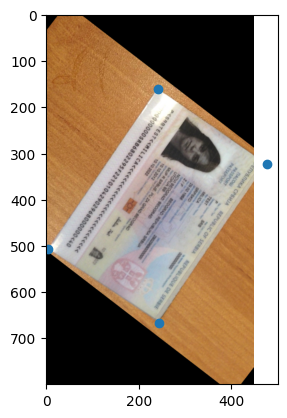

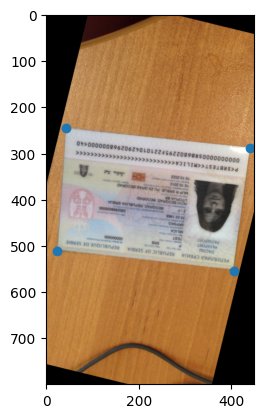

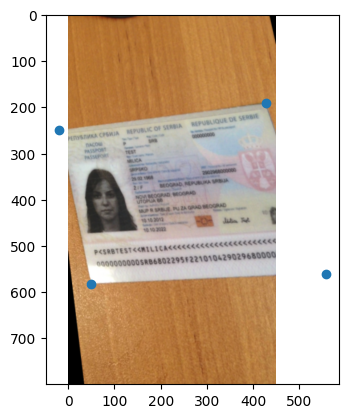

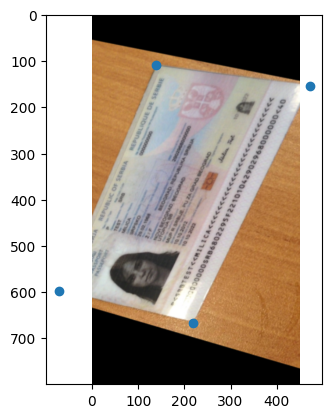

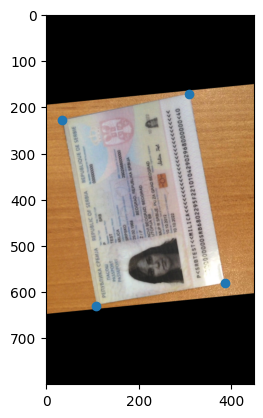

In [16]:
i = 0
for img, labels in observation_train:
    # plt.title(labels)
    plt.imshow(img)
    plt.scatter(labels[::2], labels[1::2])
    plt.show()
    if i > 3:
        break
    i+= 1

##Гиперпараметры

In [27]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MEAN = (0.4914, 0.4822, 0.4465)
STD = (0.2023, 0.1994, 0.2010)

TRAIN_SUBPART = 1.0
VAL_SPLIT = 0.25

BATCH_SIZE = 36
MAX_EPOCHS = 10
# BASE_LR = 1e-1 #- для 1-ой модели
BASE_LR = 1e-2 # - для второй модели
# BASE_LR = 1e-3 # - попытка доучить вторую модель


DEFAULT_TRANSFORM = A.Compose(
    [
        # A.Flip(),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),

    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

##Классы и функции для модели и обучения

In [ ]:
!mkdir checkpoints

In [28]:
class KeypointDataModule(pl.LightningDataModule):
    def __init__(
        self,
        dataset,
        batch_size=BATCH_SIZE,
        train_transform=DEFAULT_TRANSFORM,
    ):
        super().__init__()

        self.batch_size = batch_size

        self.train_set = KeyPointDataset(
            dataset = dataset,
            with_points = True,
            transform = train_transform
        )

        indices = list(range(len(self.train_set)))
        np.random.shuffle(indices)
        indices = indices[: int(round(len(indices) * TRAIN_SUBPART))]
        split = int(round(VAL_SPLIT * len(indices)))

        self.train_sampler = SubsetRandomSampler(indices[split:])
        self.val_sampler = SubsetRandomSampler(indices[:split])

    def setup(self, stage):
        print(
            f"Train: {len(self.train_sampler)} images\n"
            f"Validation: {len(self.val_sampler)} images"
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_set,
            sampler=self.train_sampler,
            batch_size=self.batch_size,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_set,
            sampler=self.val_sampler,
            batch_size=self.batch_size,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_set,
            sampler=self.val_sampler,
            batch_size=self.batch_size,
        )


class KeyPointModel(nn.Sequential):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.BatchNorm2d(64, momentum=0.8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.head = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(256 * 11 * 11, 64),
            nn.ReLU(),
            nn.Linear(64, 8),
        )


class EfNetKeyPoinModel(pl.LightningModule):
    def __init__(self, num_points, transfer=True, freeze="most"):
        super().__init__()

        self.points_model = models.efficientnet_v2_s(
            weights=models.EfficientNet_V2_S_Weights.DEFAULT
        )

        linear_size = list(self.points_model.children())[-1][1].in_features
        self.points_model.classifier = nn.Sequential(
            nn.Linear(linear_size, 1280, bias=True),
            nn.BatchNorm1d(1280),
            nn.Hardswish(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=1280, out_features=num_points, bias=True),
        )


        for child in list(self.points_model.children()):
            for param in child.parameters():
                param.requires_grad = True

        if freeze == "last":
            for child in list(self.points_model.children())[:-1]:
                for param in child.parameters():
                    param.requires_grad = False
        elif freeze == "most":
            for child in list(self.points_model.children())[0][:-2]:
                for param in child.parameters():
                    param.requires_grad = False
        elif freeze != "full":
            raise NotImplementedError("Wrong freezing parameter")

    def forward(self, x):
        return self.points_model(x)


class KeyPointTrainingModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # self.model = KeyPointModel()
        self.model = EfNetKeyPoinModel(num_points = 8)
        self.train_loss = []
        self.val_loss = []
        self.train_mse = []
        self.val_mse = []
        self.loss_func = nn.MSELoss()
        self.mse = lambda x, y: ((x - y)**2).mean()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y_gt = batch
        y_pr = self.model(x)
        loss = self.loss_func(y_pr, y_gt)
        self.train_loss.append(loss.detach().cpu())  # optional

        mse = self.mse(y_pr, y_gt).detach().cpu()
        self.train_mse.append(mse)
        return loss

    def configure_optimizers(self):
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=BASE_LR, weight_decay=5e-2)
        self.reduce_lr_on_plateau = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                factor=0.5,
                patience=2,
                min_lr=1e-7,
                verbose=True
            ),
            "monitor": "val_loss",
            "interval": "epoch"
        }
        return [self.optimizer], [self.reduce_lr_on_plateau]
        # return [self.optimizer]

    def on_train_epoch_end(self):
        ## display average loss across epoch
        avg_loss = torch.stack(self.train_loss).mean()
        print(
            f"Epoch {self.trainer.current_epoch}, "
            f"Train_loss: {round(float(avg_loss), 5)}",
        )
        # don't forget to clear the saved losses
        self.train_loss.clear()

    def on_train_epoch_end(self):
        ## display average loss across epoch
        avg_loss = torch.stack(self.train_loss).mean()
        avg_mse = torch.stack(self.train_mse).mean()
        print(
            f"\nEpoch {self.trainer.current_epoch}, "
            f"Train_mse: {round(float(avg_mse), 5)}, "
            f"Train_loss: {round(float(avg_loss), 5)}",
        )
        # don't forget to clear the saved losses
        self.train_loss.clear()

    def on_validation_epoch_end(self):
        ## display average loss across epoch
        avg_loss = torch.stack(self.val_loss).mean()
        avg_mse = torch.stack(self.val_mse).mean()
        print(
            f"\nEpoch {self.trainer.current_epoch}, "
            f"Val_mse: {round(float(avg_mse), 5)}, "
            f"Val_loss: {round(float(avg_loss), 5)} "
        )
        # don't forget to clear the saved losses
        self.val_loss.clear()

    def validation_step(self, batch, batch_idx):
        """the full validation loop"""
        x, y_gt = batch
        y_pr = self.model(x)
        loss = self.loss_func(y_pr, y_gt)
        self.val_loss.append(loss.detach().cpu())

        mse = self.mse(y_pr, y_gt).detach().cpu()
        self.val_mse.append(mse)

        metrics = {"val_mse": mse, "val_loss": loss}

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=False)
        return metrics


def read_img_shapes(gt_dir):
    img_shapes = {}
    with open(os.join(gt_dir, 'img_shapes.csv')) as fhandle:
        next(fhandle)
        for line in fhandle:
            parts = line.rstrip('\n').split(',')
            filename = parts[0]
            n_rows, n_cols = map(int, parts[1:])
            img_shapes[filename] = (n_rows, n_cols)
    return img_shapes


def inference(trained_model, images_path):
    trained_model.eval().to(DEVICE)
    dataset = KeyPointDataset(images_path, with_points=False, transform=DEFAULT_TRANSFORM)
    img_names = dataset.ann_df["img_key"]
    res_dict = {}
    for i, ((img_tensor, _), img_name) in tqdm(
        enumerate(zip(dataset, img_names)), desc="inference", total=len(dataset)
    ):
        img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            points = trained_model(img_tensor).squeeze(0).detach().cpu().numpy()

        w = dataset.ann_df.loc[i, "img_width"]
        h = dataset.ann_df.loc[i, "img_height"]
        points[::2] = points[::2]
        points[1::2] = points[1::2]
        points
        res_dict[img_name] = list(points)
    return res_dict


def train_detector(dataset):
    data_module = KeypointDataModule(
        dataset = dataset,
        batch_size=BATCH_SIZE,
        train_transform=DEFAULT_TRANSFORM,
    )

    model = KeyPointTrainingModule()

    # model = KeyPointTrainingModule.load_from_checkpoint(
    #     "/content/course_ocr/task1/best.ckpt",
    #     map_location = DEVICE,
    # )

    checkpoint_callback = ModelCheckpoint(
        dirpath="/content/course_ocr/task1/checkpoints",
        filename="{epoch}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=1,
    )

    trainer = pl.Trainer(
        callbacks=[checkpoint_callback],
        max_epochs=MAX_EPOCHS,
        accelerator=DEVICE,
        devices=1,
        enable_progress_bar=False,
        gradient_clip_val=1
    )
    trainer.fit(model, data_module)
    return model

##Обучение

In [19]:
# model = train_detector(train_dataset)

##Сохранение чекпоинтов

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/course_ocr/task1/checkpoints/epoch=2.ckpt /content/drive/MyDrive  #best.ckpt
!cp /content/course_ocr/task1/checkpoints/last.ckpt /content/drive/MyDrive

##Просмотр результатов и перевод выходных данных в нужный формат

In [20]:
data = []

for dp in tqdm(data_packs):
  for i in range(len(dp)):
    if dp[i].is_test_split():
      line = [str(dp[i].img_path), str(dp[i].unique_key)]
      data.append(line)

test_dataset = pd.DataFrame(data,columns=['img_path', 'img_key'])

100%|██████████| 50/50 [00:00<00:00, 204.27it/s]


In [21]:
test_dataset.head()

img_path  \
0  /content/course_ocr/task1/midv500_compressed/4...   
1  /content/course_ocr/task1/midv500_compressed/4...   
2  /content/course_ocr/task1/midv500_compressed/4...   
3  /content/course_ocr/task1/midv500_compressed/4...   
4  /content/course_ocr/task1/midv500_compressed/4...   

                                        img_key  
0  41_srb_passport|ground_truth|TA|TA41_26.json  
1  41_srb_passport|ground_truth|TA|TA41_27.json  
2  41_srb_passport|ground_truth|TA|TA41_28.json  
3  41_srb_passport|ground_truth|TA|TA41_29.json  
4  41_srb_passport|ground_truth|TA|TA41_30.json

In [ ]:
model = KeyPointTrainingModule.load_from_checkpoint(
    "/content/course_ocr/task1/first_best.ckpt",
    map_location = DEVICE,
)

In [29]:
predictions = inference(model, test_dataset)
# predictions

inference: 100%|██████████| 4250/4250 [02:25<00:00, 29.11it/s]


In [30]:
with open('/content/course_ocr/task1/gt.json') as json_file:
    gt = json.load(json_file)
# gt

36_pol_drvlic|ground_truth|KS|KS36_28.json
0.9455013195777104


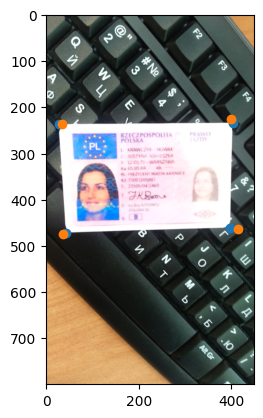

44_ukr_id|ground_truth|HA|HA44_21.json
0.9169836730463787


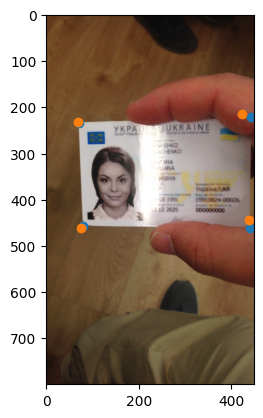

47_usa_bordercrossing|ground_truth|PA|PA47_12.json
0.8133992873277175


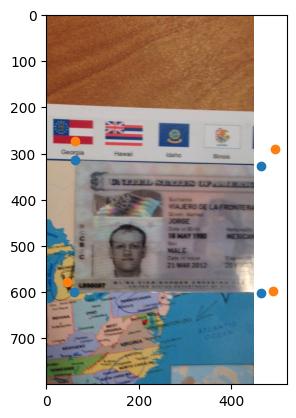

44_ukr_id|ground_truth|HS|HS44_04.json
0.9406405042986764


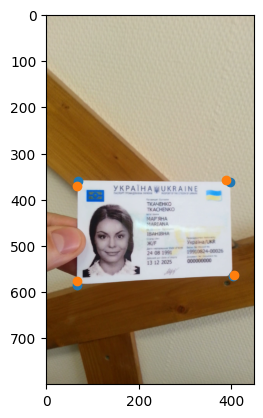

44_ukr_id|ground_truth|HA|HA44_09.json
0.9068292392474198


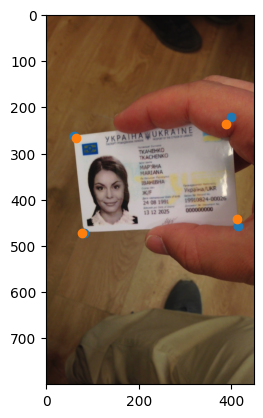

20_esp_id_new|ground_truth|HS|HS20_29.json
0.941159454169515


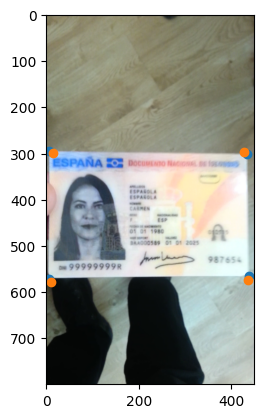

19_esp_drvlic|ground_truth|CS|CS19_28.json
0.923332732597044


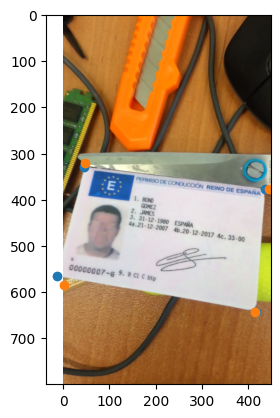

45_ukr_passport|ground_truth|KS|KS45_14.json
0.8866174499813714


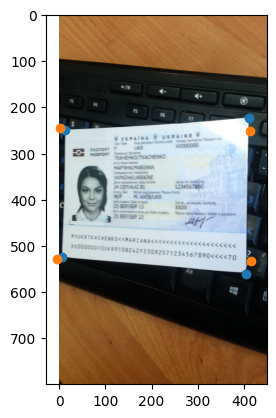

13_deu_drvlic_old|ground_truth|PA|PA13_27.json
0.8958428807614836


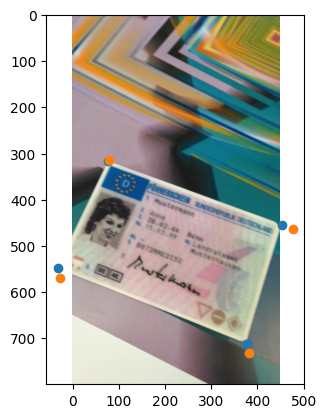

06_bra_passport|ground_truth|PA|PA06_29.json
0.8807452832717447


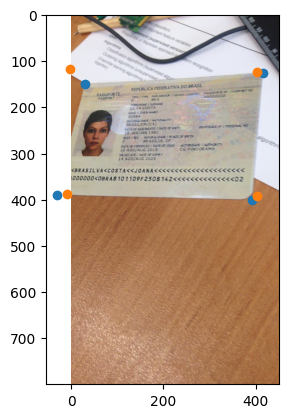

In [31]:
idx = np.random.randint(0,len(test_dataset), 10)
# idx = np.random.randint(0,2920, 10)
for i in idx:
  imd_path, img_key, _, _ = test_dataset.iloc[i]
  gt_sample = np.array(gt[img_key])  * np.array([450, 800])
  pred_sample = np.reshape(predictions[img_key], (4,2))
  print(img_key)
  print(iou_relative_quads(gt_sample  * np.array([1/450, 1/800]), pred_sample * np.array([1/450, 1/800])))
  img = cv2.imread(imd_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.scatter(gt_sample[:,0], gt_sample[:,1])
  plt.scatter(pred_sample[:,0], pred_sample[:,1])
  plt.show()

In [32]:
reshaped_predictions = {k:np.reshape(v, (4,2)).tolist() for k, v in predictions.items()}
norm_pred = {k:(np.array(v) * np.array([1/450, 1/800])).tolist() for k, v in reshaped_predictions.items()}

In [33]:
with open('/content/course_ocr/task1/first_pred.json', 'w') as fp:
    json.dump(norm_pred, fp)

##Подсчет метрики

In [34]:
for t in [0.8, 0.85, 0.9, 0.95]:
    acc = measure_crop_accuracy(
        '/content/course_ocr/task1/gt.json',
        '/content/course_ocr/task1/first_pred.json',
        iou_thr=t,
    )
    print(f"Точность кропа при t = {t}: {acc}")

Точность кропа при t = 0.8: 0.9618823529411765
Точность кропа при t = 0.85: 0.9312941176470588
Точность кропа при t = 0.9: 0.8275294117647058
Точность кропа при t = 0.95: 0.32423529411764707


#Второй метод

##Подготовка трейна

In [ ]:
# !pip install brains
# !rm sadness
# !pip install hope

# from brains import knowledge
# from hope import believe.in.self

In [58]:
data = []

for dp in data_packs:
  for i in range(len(dp)):
    if not dp[i].is_test_split():
      flat_list = [
          x
          for xs in dp[i].gt_data['quad']
          for x in xs
      ]
      line = [str(dp[i].img_path)] + flat_list
      data.append(line)

train_dataset = pd.DataFrame(data,columns=['img_path', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])

print(f'Предыдущая длина трейна = {len(train_dataset)}')

#дальше будет паддинг, чтобы не было гиганских размеров картинок, немного чищу трейн
#(почему именно 200) можно посмотреть по графикам в пункте ниже (ячейки запущены до выполнения этой ячейки)

for i in range(1,5):
  train_dataset = train_dataset[train_dataset[f'x{i}'] > -200]
  train_dataset = train_dataset[train_dataset[f'x{i}'] < 450 + 200]
  train_dataset = train_dataset[train_dataset[f'y{i}'] > -200]
  train_dataset = train_dataset[train_dataset[f'y{i}'] < 800 + 200]
print(f'Длина трейна после чистки = {len(train_dataset)}')

Предыдущая длина трейна = 10750
Длина трейна после чистки = 10203


In [59]:
class SegmentationDataset(Dataset):
    def __init__(
        self,
        dataset,
        with_points=False,
        transform=None,
    ):
        if with_points:
          self.ann_df = dataset
          columns = ['img_links', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4']
        else:
          self.ann_df = dataset
          columns = []
        self.ann_df["img_width"] = [0] * len(self.ann_df)
        self.ann_df["img_height"] = [0] * len(self.ann_df)
        self.transform = transform
        self.feature_columns = columns[1:]

    def create_binary_mask(self, rectangle_points, image_shape):
      mask = np.zeros(image_shape, dtype=np.uint8)
      rectangle_points = np.array(rectangle_points, np.int32)
      rectangle_points = rectangle_points.reshape((-1, 1, 2))
      cv2.fillPoly(mask, [rectangle_points], color=(255, 255, 255))

      mask = (mask > 0).astype(np.int64)

      return mask


    def __len__(self):
        return self.ann_df.shape[0]

    def __getitem__(self, index, pad = ((209, 207), (209, 205))):
        row = self.ann_df.iloc[index]

        ## read image
        image = cv2.imread(row["img_path"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.stack([np.pad(image[:,:,c], pad, mode='constant', constant_values=0) for c in range(3)], axis=2)
        h, w, _ = image.shape
        self.ann_df.loc[index, "img_width"] = w
        self.ann_df.loc[index, "img_height"] = h
        if len(self.feature_columns) > 0:
            features = row[self.feature_columns].values.astype(np.float32)
            keypoints = features.reshape((len(features) // 2, 2)) + (pad[0][1], pad[0][0])
            mask = self.create_binary_mask(keypoints, (h,w))
        if self.transform:
            if len(self.feature_columns) > 0:
                transformed = self.transform(image=image)
                image = transformed["image"]
                mask = torch.from_numpy(mask).unsqueeze(0)
            else:
                transformed = self.transform(image=image)
                image = transformed["image"]

        if len(self.feature_columns) > 0:
            return image, mask
        else:
            return image, None

In [60]:
observation_train = SegmentationDataset(train_dataset, with_points=True, transform=None)

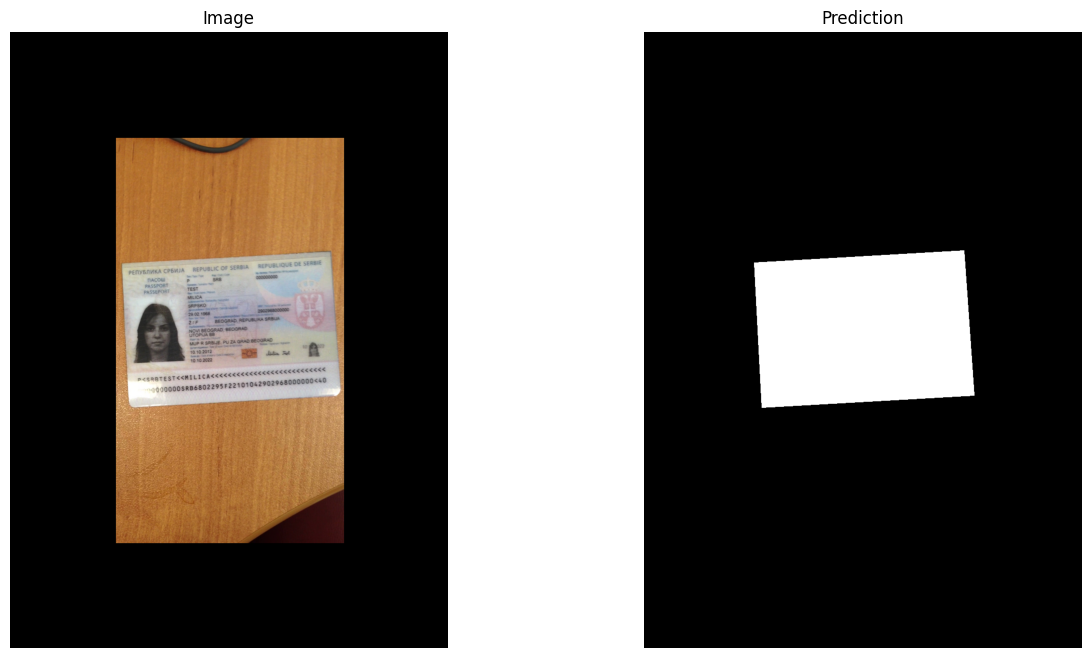

In [61]:
for img, mask in observation_train:
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap = "gray")
    plt.title("Prediction")
    plt.axis("off")

    break

##Графики для выбора оптимальных размеров паддинга

In [50]:
min_max_arr = []
for j, dp in tqdm(enumerate(data_packs)):
  for i in range(len(dp)):
    if not dp[i].is_quad_inside():
      min_i_x, min_i_y = np.min(dp[i].gt_data['quad'], axis = 0)
      max_i_x, max_i_y = np.max(dp[i].gt_data['quad'], axis = 0)
      min_max_arr.append([min_i_x, min_i_y, max_i_x, max_i_y, j, i])

50it [00:00, 58.41it/s]


In [53]:
min_max_arr = np.array(min_max_arr)

<Axes: >

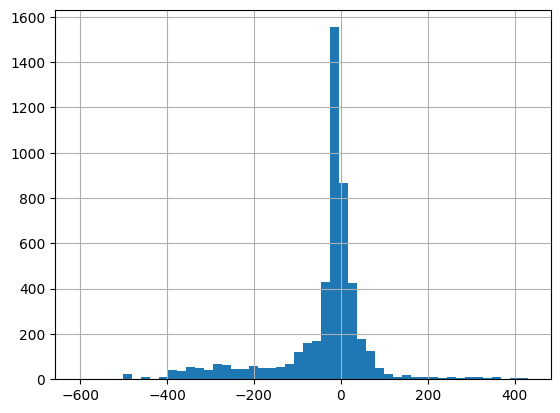

In [54]:
pd.Series(min_max_arr[:,0]).hist(bins = 50)

<Axes: >

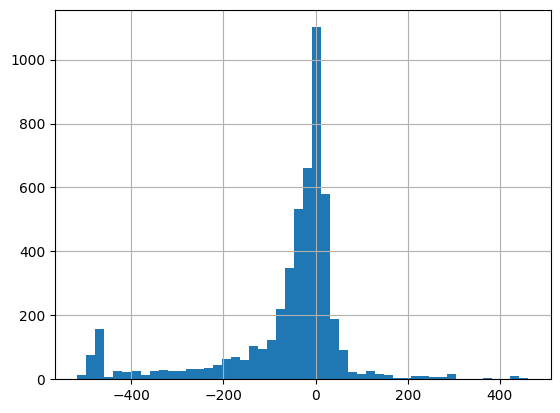

In [55]:
pd.Series(min_max_arr[:,2] - 450).hist(bins = 50)

<Axes: >

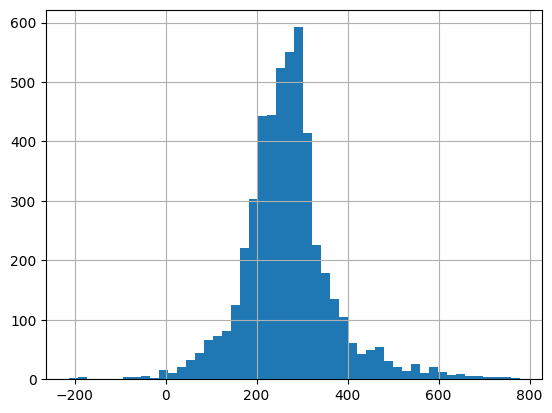

In [56]:
pd.Series(min_max_arr[:,1]).hist(bins = 50)

<Axes: >

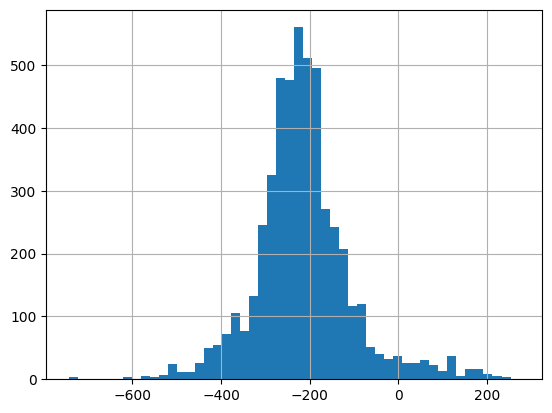

In [57]:
pd.Series(min_max_arr[:,3] - 800).hist(bins = 50)

##Гиперпараметры

In [62]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MEAN = (0.4914, 0.4822, 0.4465)
STD = (0.2023, 0.1994, 0.2010)

TRAIN_SUBPART = 1.0
VAL_SPLIT = 0.15

BATCH_SIZE = 8
DEFAULT_TRANSFORM = A.Compose(
    [
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2()
    ]
)

##Классы и функции для модели и обучения

In [63]:
def dice_coef(mask_pred_prob, mask_gt, threshold=0.5):
    mask_pred = (mask_pred_prob > threshold) * 1
    b = mask_pred.sum() + mask_gt.sum()
    if b == 0:
        return 1
    a = (mask_pred[mask_gt > 0]).sum() * 2.0
    return a / b


class LightningDocumentSegmenter(pl.LightningModule):
    def __init__(
        self,
        encoder_name,
        arch,
        train_batches,
        lr_rate=5e-4,
        warmup_batches=0,
        scheduler_patience=2,
        scheduler_factor=0.5,
        weight_decay=1e-2,
        max_epochs=6,
    ):
        super(LightningDocumentSegmenter, self).__init__()

        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=3, classes=1
        )
        self.lr_rate = lr_rate
        self.train_loss = []
        self.val_loss = []
        self.lrs = []
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.save_hyperparameters()
        self.warmup_steps = warmup_batches
        self.train_steps = train_batches
        self.scheduler_patience = scheduler_patience
        self.scheduler_factor = scheduler_factor
        self.weight_decay = weight_decay
        self.max_epochs = max_epochs

    def forward(self, x):
        return self.model(x)

    def __log_metrics(self, logits_mask, mask, loss, mode):
        probs = logits_mask.sigmoid()
        tp, fp, fn, tn = smp.metrics.get_stats(
            probs, mask, mode="binary", threshold=0.5
        )
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        dice = dice_coef(probs, mask)
        metrics_dict = {f"{mode}_iou": iou_score, f"{mode}_dice": dice}
        self.log_dict(metrics_dict, on_step=False, on_epoch=True)
        if loss is not None:
            self.log(f"{mode}_loss", loss, on_step=False, on_epoch=True, prog_bar=False)

    def training_step(self, train_batch, batch_idx):
        x, mask = train_batch
        logits_mask = self.forward(x)
        loss = self.loss_fn(logits_mask, mask)
        self.train_loss.append(loss.item())

        self.__log_metrics(logits_mask, mask, loss, "train")

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.log("lr", current_lr, on_step=True, on_epoch=False, prog_bar=False)
        self.lrs.append(current_lr)
        return {"loss": loss}

    def validation_step(self, val_batch, batch_idx):
        x, mask = val_batch
        logits_mask = self.forward(x)
        loss = self.loss_fn(logits_mask, mask)
        self.val_loss.append(loss.item())

        self.__log_metrics(logits_mask, mask, loss, "val")

        return {"val_loss": loss}

    def test_step(self, val_batch, batch_idx):
        x, mask = val_batch
        logits_mask = self.forward(x)

        self.__log_metrics(logits_mask, mask, None, "test")

        return {}

    def on_train_epoch_end(self):
        avg_loss = np.mean(self.train_loss)
        print(
            f"\nEpoch {self.trainer.current_epoch}, "
            f"Train_loss: {round(float(avg_loss), 5)} "
        )
        self.train_loss.clear()

    def on_validation_epoch_end(self):
        avg_loss = np.mean(self.val_loss)
        print(
            f"\nEpoch {self.trainer.current_epoch}, "
            f"Val_loss: {round(float(avg_loss), 5)} "
        )
        self.val_loss.clear()

    def configure_optimizers(self):
        self.optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.lr_rate, weight_decay=self.weight_decay
        )
        self.reduce_lr_on_plateau = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                factor=self.scheduler_factor,
                patience=self.scheduler_patience,
                min_lr=1e-7,
                verbose=True,
            ),
            "monitor": "val_loss",
            "interval": "epoch",
        }
        return [self.optimizer], [self.reduce_lr_on_plateau]


In [64]:
class KeypointDataModule(pl.LightningDataModule):
    def __init__(
        self,
        dataset,
        batch_size=BATCH_SIZE,
        train_transform=DEFAULT_TRANSFORM,
    ):
        super().__init__()

        self.batch_size = batch_size

        self.train_set = SegmentationDataset(
            dataset = dataset,
            with_points = True,
            transform = train_transform
        )

        indices = list(range(len(self.train_set)))
        np.random.shuffle(indices)
        indices = indices[: int(round(len(indices) * TRAIN_SUBPART))]
        split = int(round(VAL_SPLIT * len(indices)))

        self.train_sampler = SubsetRandomSampler(indices[split:])
        self.val_sampler = SubsetRandomSampler(indices[:split])
        # self.test_sampler = SubsetRandomSampler(indices)

    def setup(self, stage):
        print(
            f"Train: {len(self.train_sampler)} images\n"
            f"Validation: {len(self.val_sampler)} images"
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_set,
            sampler=self.train_sampler,
            batch_size=self.batch_size,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_set,
            sampler=self.val_sampler,
            batch_size=self.batch_size,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_set,
            # sampler=self.test_sampler,
            batch_size=self.batch_size,
        )

In [65]:
data_module = KeypointDataModule(
        dataset = train_dataset,
        batch_size=BATCH_SIZE,
        train_transform=DEFAULT_TRANSFORM,
    )

##Обучение

In [66]:
MAX_EPOCHS = 5
BASE_LR = 1e-4
SCHEDULER_FACTOR = 0.1
SCHEDULER_PATIENCE = 2
WARMUP_STEPS = 0
WEIGHT_DECAY = 1e-2
num_train_batches = len(data_module.train_dataloader())

In [ ]:
!mkdir segm_checkpoints

In [ ]:
model = LightningDocumentSegmenter(
    encoder_name="resnet18",
    arch="Unet",
    train_batches=num_train_batches,
    lr_rate=BASE_LR,
    warmup_batches = WARMUP_STEPS,
    scheduler_patience = SCHEDULER_PATIENCE,
    scheduler_factor = SCHEDULER_FACTOR,
    weight_decay = WEIGHT_DECAY,
    max_epochs=MAX_EPOCHS,
)

checkpoint_callback = ModelCheckpoint(
    dirpath="/content/course_ocr/task1/segm_checkpoints",
    filename="{epoch}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=1,
)

trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    max_epochs=MAX_EPOCHS,
    accelerator=DEVICE,
    devices=1,
    enable_progress_bar=False,
    gradient_clip_val=1
)

# trainer.fit(model, data_module)

##Просмотр результатов и перевод данных в нужный формат

In [68]:
data = []

for dp in tqdm(data_packs):
  for i in range(len(dp)):
    if dp[i].is_test_split():
      line = [str(dp[i].img_path), str(dp[i].unique_key)]
      data.append(line)

test_dataset = pd.DataFrame(data,columns=['img_path', 'img_key'])

100%|██████████| 50/50 [00:00<00:00, 193.58it/s]


In [69]:
test_dataset.head()

img_path  \
0  /content/course_ocr/task1/midv500_compressed/4...   
1  /content/course_ocr/task1/midv500_compressed/4...   
2  /content/course_ocr/task1/midv500_compressed/4...   
3  /content/course_ocr/task1/midv500_compressed/4...   
4  /content/course_ocr/task1/midv500_compressed/4...   

                                        img_key  
0  41_srb_passport|ground_truth|TA|TA41_26.json  
1  41_srb_passport|ground_truth|TA|TA41_27.json  
2  41_srb_passport|ground_truth|TA|TA41_28.json  
3  41_srb_passport|ground_truth|TA|TA41_29.json  
4  41_srb_passport|ground_truth|TA|TA41_30.json

In [71]:
new_last = LightningDocumentSegmenter.load_from_checkpoint(
    "/content/course_ocr/task1/final_best.ckpt",
    map_location = DEVICE,
)

In [72]:
def get_coord(pr_mask):
    ret, thresh = cv2.threshold(pr_mask, 0.8, 1.05, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(image=np.array(thresh, np.uint8), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    if len(contours) == 0:
      return np.zeros((4,2))
    coords = np.squeeze(max(contours, key=len)) - (207,209)
    polygon = Polygon(coords).convex_hull
    b = np.array((polygon.simplify(30).exterior.coords))
    poli_cord = np.vstack([b, b[1]])
    while(len(poli_cord) > 6):
            angles = []
            for i in range(len(poli_cord) - 2):
                angle_points = poli_cord[i : i + 3]
                v1 = angle_points[-1] - angle_points[1]
                v2 = angle_points[0] - angle_points[1]
                cos = (v1 * v2).sum() / np.linalg.norm(v1) / np.linalg.norm(v2)
                angle = (
                    np.arccos(cos)
                    / 2
                    / np.pi
                    * 360
                )
                angles.append(angle)
            idx = np.argmax(angles) + 1
            if idx == len(angles):
              idx = 0
            poli_cord = np.vstack([poli_cord[:idx], poli_cord[idx+1:]])
    poli_cord = poli_cord[:-2]


    pr_coord = np.array(poli_cord * np.array([1/450, 1/800]))
    return pr_coord

In [73]:
def mask_inference(trained_model, dataset):
    trained_model.eval().to(DEVICE)
    dataset = SegmentationDataset(dataset, with_points=False, transform=DEFAULT_TRANSFORM)
    img_names = dataset.ann_df["img_key"]
    res_dict = {}
    for i, ((img_tensor, _), img_name) in tqdm(
        enumerate(zip(dataset, img_names)), desc="inference", total=len(dataset)
    ):
        img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            mask = trained_model(img_tensor).sigmoid().squeeze(0).cpu().numpy()
        # res_dict[img_name] = get_coord(mask.squeeze())
        res_dict[img_name] = mask.squeeze()

    return res_dict

In [ ]:
mask_redictions = mask_inference(new_last, test_dataset.head(10))

41_srb_passport|ground_truth|KS|KS41_28.json


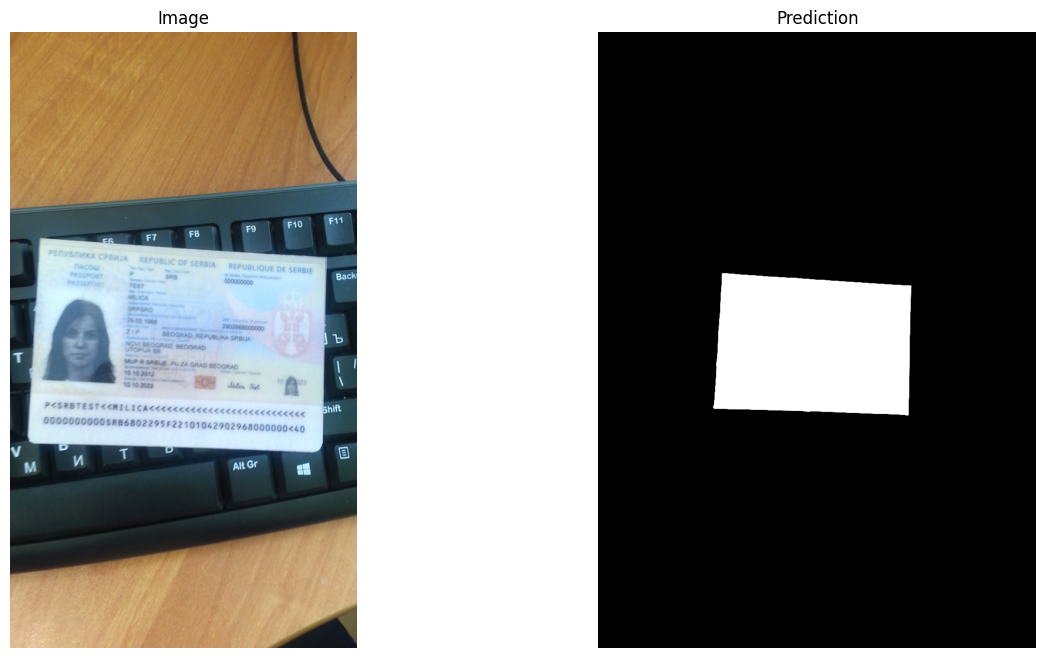

41_srb_passport|ground_truth|KS|KS41_29.json


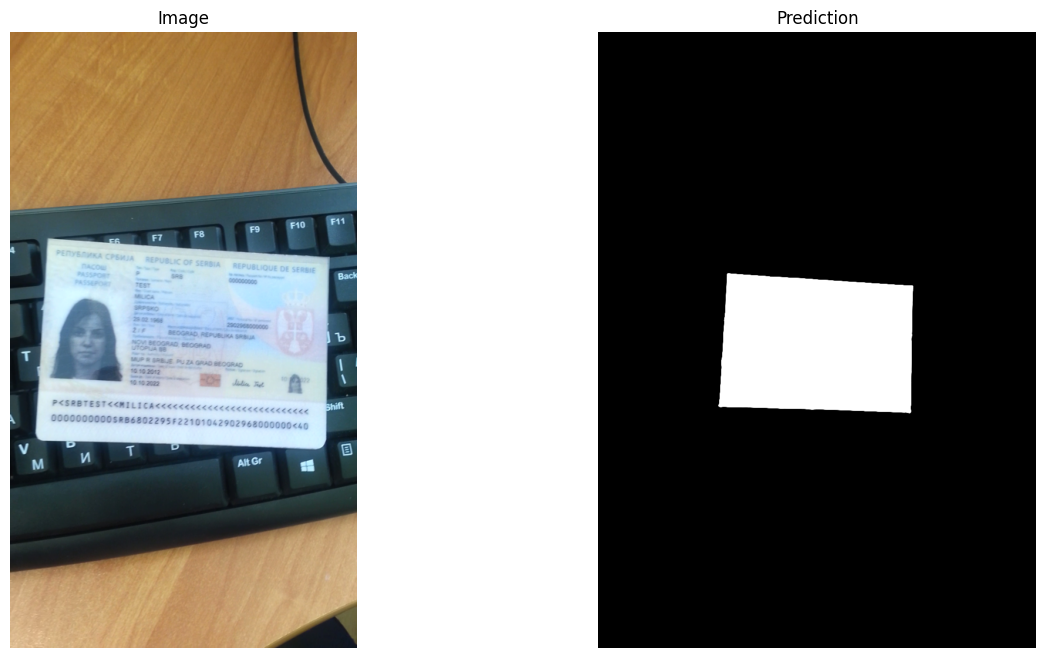

41_srb_passport|ground_truth|TA|TA41_29.json


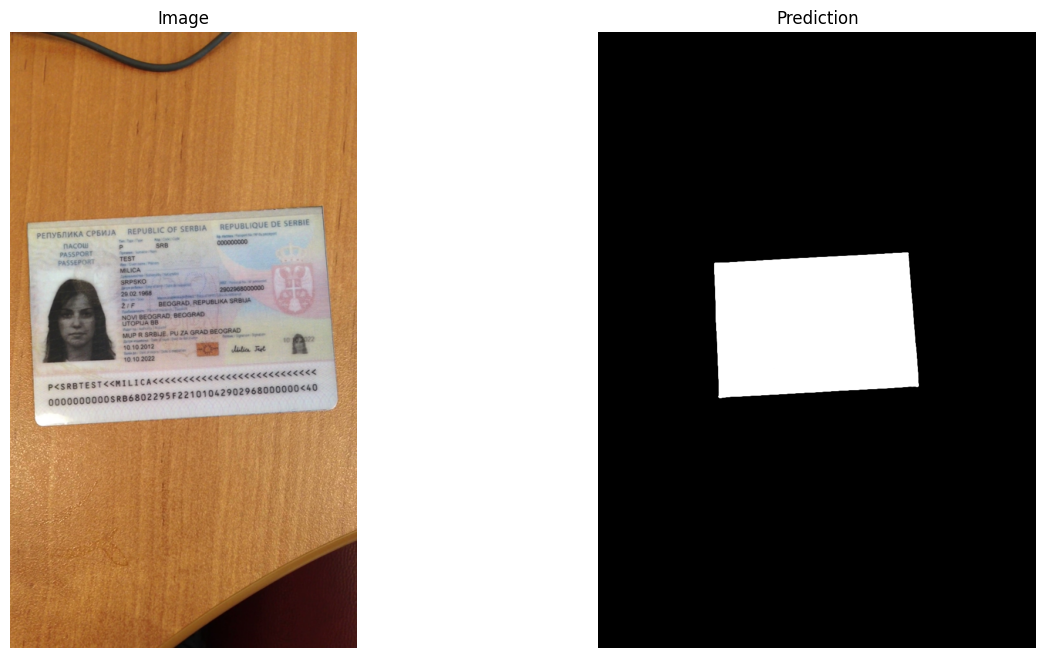

In [75]:
idx = np.random.randint(0,len(test_dataset.head(10)), 3)

for i in idx:
  imd_path, img_key = test_dataset.iloc[i]
  img = cv2.imread(imd_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  print(img_key)
  mask = mask_redictions[img_key]

  plt.figure(figsize=(15, 8))
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  plt.title("Image")
  plt.axis("off")

  plt.subplot(1, 2, 2)
  plt.imshow(mask, cmap = "gray")
  plt.title("Prediction")
  plt.axis("off")

  plt.show()

In [76]:
def inference(trained_model, dataset):
    trained_model.eval().to(DEVICE)
    dataset = SegmentationDataset(dataset, with_points=False, transform=DEFAULT_TRANSFORM)
    img_names = dataset.ann_df["img_key"]
    res_dict = {}
    for i, ((img_tensor, _), img_name) in tqdm(
        enumerate(zip(dataset, img_names)), desc="inference", total=len(dataset)
    ):
        img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            mask = trained_model(img_tensor).sigmoid().squeeze(0).cpu().numpy()
        res_dict[img_name] = get_coord(mask.squeeze())
        # res_dict[img_name] = mask.squeeze()

    return res_dict

In [77]:
predictions = inference(new_last, test_dataset)

inference: 100%|██████████| 4250/4250 [05:02<00:00, 14.06it/s]


In [78]:
with open('/content/course_ocr/task1/gt.json') as json_file:
    gt = json.load(json_file)
# gt

47_usa_bordercrossing|ground_truth|TS|TS47_13.json
0.9893544013871305


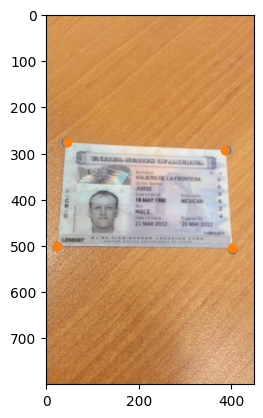

44_ukr_id|ground_truth|PS|PS44_22.json
0.98739207160066


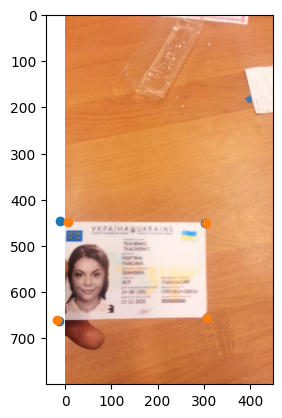

33_mac_id|ground_truth|TA|TA33_30.json
0.9643216652808898


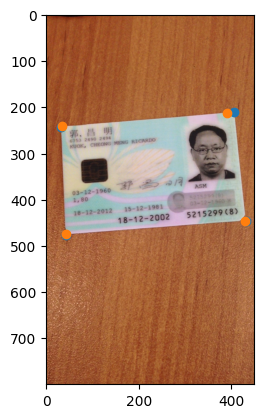

44_ukr_id|ground_truth|PS|PS44_30.json
0.9824180561762812


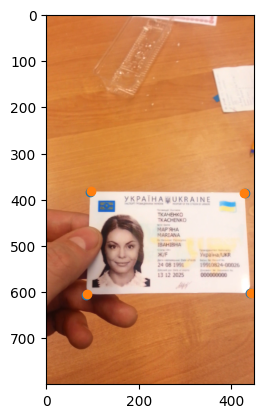

02_aut_drvlic_new|ground_truth|HA|HA02_27.json
0.9623629257277853


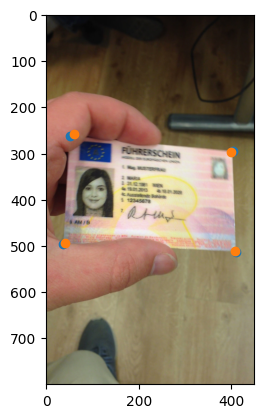

48_usa_passportcard|ground_truth|PA|PA48_26.json
0.9670898587570248


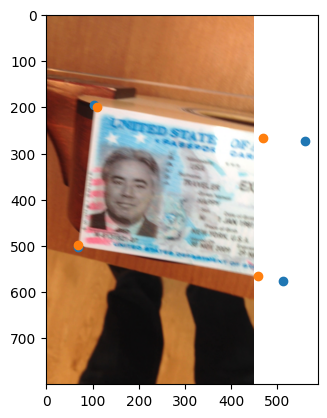

08_chn_homereturn|ground_truth|KS|KS08_28.json
0.9855742335934742


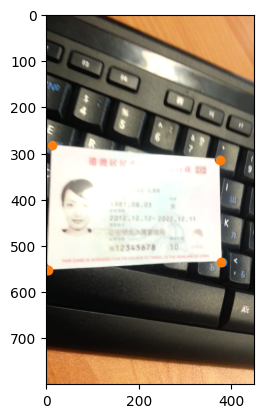

50_xpo_id|ground_truth|KA|KA50_30.json
0.9526826860753907


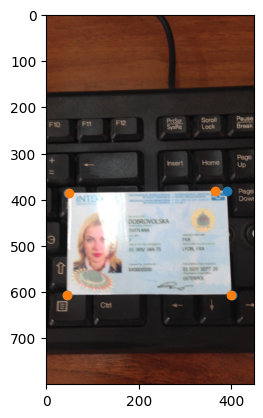

45_ukr_passport|ground_truth|TS|TS45_10.json
0.994587907275686


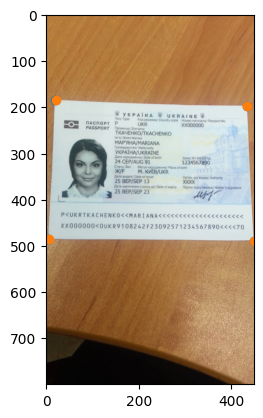

25_grc_passport|ground_truth|HA|HA25_28.json
0.9878356713027605


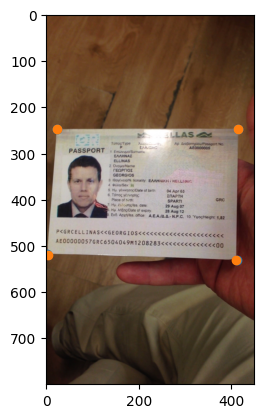

In [80]:
idx = np.random.randint(0,len(test_dataset), 10)

for i in idx:
  imd_path, img_key, _, _ = test_dataset.iloc[i]
  gt_sample = np.array(gt[img_key])  * np.array([450, 800])
  pred_sample = np.reshape(predictions[img_key], (4,2)) * np.array([450, 800])
  print(img_key)
  print(iou_relative_quads(gt_sample * np.array([1/450, 1/800]), pred_sample * np.array([1/450, 1/800])))
  img = cv2.imread(imd_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.scatter(gt_sample[:,0], gt_sample[:,1])
  plt.scatter(pred_sample[:,0], pred_sample[:,1])
  plt.show()

In [81]:
pr_list = {k:v.tolist() for k, v in predictions.items()}

In [82]:
with open('/content/course_ocr/task1/pred_quads.json', 'w') as fp:
    json.dump(pr_list, fp)

##Подсчет метрики

In [83]:
for t in [0.8, 0.85, 0.9, 0.95]:
    acc = measure_crop_accuracy(
        '/content/course_ocr/task1/gt.json',
        '/content/course_ocr/task1/pred_quads.json',
        iou_thr=t,
    )
    print(f"Точность кропа при t = {t}: {acc}")

Точность кропа при t = 0.8: 0.9541176470588235
Точность кропа при t = 0.85: 0.9447058823529412
Точность кропа при t = 0.9: 0.9185882352941176
Точность кропа при t = 0.95: 0.8531764705882353
